Trying to use more than 1 latent variable

In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
from gpfa_imputation.imputation import *
from gpfa_imputation.data_preparation import *

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from pyprojroot import here
import matplotlib.pyplot as plt

from IPython.display import HTML

from ipywidgets import HBox, VBox, interact, widgets
from ipywidgets.widgets import Output
from fastcore.foundation import patch

In [3]:
torch.manual_seed(27);
np.random.seed(27);

## Load Data

take the first 200 rows from the Hainich dataset

In [4]:
hai_path = Path("FLX_DE-Hai_FLUXNET2015_FULLSET_HH_2000-2012_1-4.csv")
hai_raw = pd.read_csv(here("data") / hai_path, na_values=["-9999", "-9999.99"], parse_dates=[0, 1], nrows=200)

In [5]:
meteo_vars = {
    "TA_F": "TA",
    "SW_IN_F": "SW_IN",
    "LW_IN_F": "LW_IN",
    "VPD_F": "VPD",
    #"PA": "PA"
}

units = {
    'TA': '°C',
    'SW_IN': 'W m-2',
    'LW_IN': 'W m-2',
    'VPD': 'hPa'
}

hai = (hai_raw
       .rename(columns=meteo_vars)
       .set_index("TIMESTAMP_END")
       .loc[:, meteo_vars.values()])
hai

,TA,SW_IN,LW_IN,VPD
TIMESTAMP_END,,,,
2000-01-01 00:30:00,-0.60,0.0,302.475,0.222
2000-01-01 01:00:00,-0.65,0.0,302.475,0.122
2000-01-01 01:30:00,-0.58,0.0,301.677,0.090
2000-01-01 02:00:00,-0.51,0.0,301.677,0.110
2000-01-01 02:30:00,-0.49,0.0,301.677,0.102
...,...,...,...,...
2000-01-05 02:00:00,4.74,0.0,330.202,1.191
2000-01-05 02:30:00,4.75,0.0,330.202,1.057
2000-01-05 03:00:00,4.76,0.0,330.202,0.935


## Random Gaps

In [6]:
gpfa_data = GPFADataTest(hai[:100]).add_random_missing()

In [7]:
gpfa_hai = GPFAImputation(gpfa_data.data, gpfa_data.tidy_df(complete=True, is_missing=True), latent_dims=2)

In [8]:
gpfa_hai

GPFA Imputation:
    N obs: 100
    N features 4 (TA, SW_IN, LW_IN, VPD)
    N missing observations 102

In [9]:
%time imputed = gpfa_hai.impute()

  0%|          | 0/100 [00:00<?, ?it/s]

/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/home/simone/anaconda3/envs/data-science/lib/python3.10/site-packages/torch/autograd/__init__.py:173: UserWarning: operator() profile_node %840 : int[] = prim::profile_ivalue(%838)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  Variable._execution_engine.run_backward(  # Calls into the C++ eng

CPU times: user 1min 58s, sys: 485 ms, total: 1min 59s
Wall time: 1min 59s


In [10]:
imputed

,time,variable,mean,std
0,0.0,TA,-0.600000,NaN
1,2.0,TA,-0.580000,NaN
2,3.0,TA,-0.510000,NaN
3,4.0,TA,-0.490000,NaN
4,5.0,TA,-0.400000,NaN
...,...,...,...,...
167,88.0,VPD,0.154000,0.000000
168,90.0,VPD,0.156473,0.106622
169,94.0,VPD,0.108577,0.106607
170,98.0,VPD,0.000000,0.000000


In [85]:
class GPFAImputationResult:
    "Train GPFA Imputation and collect all result in one output"
    def __init__(self, data, latent_dims=1):
        self.data = data
        self.latent_dims = latent_dims
        self.model = GPFAImputation(data.data, data.tidy_df(complete=True, is_missing=True), latent_dims=latent_dims)
    def impute(self):
        self.model.impute()
        return self
   

In [129]:
result = GPFAImputationResult(GPFADataTest(hai[:30]).add_random_missing()).impute()

  0%|          | 0/100 [00:00<?, ?it/s]

In [114]:
def _to_widget(x, title=""):
    out = Output()
    with out:
        display(HTML(f"<h4>{title}</h4>"))
        display(x)
    return out

In [138]:
def _style_df(df):
    return df.style.hide(axis="index")

In [149]:
@patch 
def display(self: GPFAImputationResult):
    plot = self.model.plot_pred(units=units, properties =  {'height': 150 , 'width': 300})
    
    r2 = self.model.r2()
    
    variables = pd.DataFrame({'variable': self.data.data.columns})
    latent_names = [f"z{i}" for i in range(self.latent_dims)]
    
    Lambda = pd.concat([
        variables,
        pd.DataFrame(
            self.model.learner.model.covar_module.Lambda.detach().cpu().numpy(),
            columns=latent_names)
    ], axis=1)
    
    
    lengthscale = pd.DataFrame({
        'latent': latent_names,
        'lengthscale': [self.model.learner.model.covar_module.latent_kernels[i].lengthscale.detach().item() for i in range(self.latent_dims)]
    })
    
    loss = plt.plot(self.model.learner.losses)
    
    
    metrics =  [_to_widget(_style_df(df), title=title) for df, title in zip([r2, Lambda, lengthscale], ["r2", "Λ", "lengthscale"])]
    metrics.append(_to_widget(loss))
    
    bottom = HBox(metrics)
    
    return VBox([_to_widget(plot), bottom])
        

In [140]:
result.display()

In [144]:
data_hai = GPFADataTest(hai[:100]).add_random_missing()

In [145]:
GPFAImputationResult(data_hai, latent_dims=1).impute().display()

  0%|          | 0/100 [00:00<?, ?it/s]

In [147]:
GPFAImputationResult(data_hai, latent_dims=2).impute().display()

  0%|          | 0/100 [00:00<?, ?it/s]

In [148]:
GPFAImputationResult(data_hai, latent_dims=3).impute().display()

  0%|          | 0/100 [00:00<?, ?it/s]

## Manual version

In [ ]:
hai_plot = gpfa_hai.plot_pred(units=units, properties =  {'height': 190 , 'width': 380})

hai_plot.save("plots/plot_hai_winter_random_gaps_2lat.vl.json")
hai_plot

/home/simone/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [ ]:
gpfa_hai.r2()

,variable,r2
0,TA,0.992238
1,SW_IN,0.585821
2,LW_IN,0.986069
3,VPD,0.924735


In [ ]:
gpfa_hai.rmse()

,variable,rmse
0,TA,0.069741
1,SW_IN,24.124145
2,LW_IN,2.602227
3,VPD,0.036142


<AxesSubplot: >

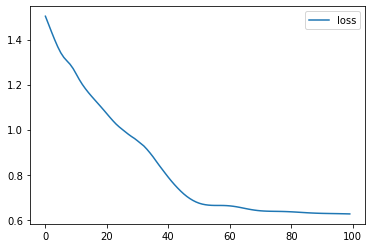

In [15]:
losses = pd.DataFrame(gpfa_hai.learner.losses.cpu().numpy(), columns=['loss'])

p = losses.plot()
plt.savefig(here('analysis/plots/loss_plot_hai_winter_4_var_200_obs_random_gaps_row_20_value_10.png'))
p

Lambda parameter, the latent variable is very similar to the 

In [17]:
gpfa_hai.learner.model.covar_module.Lambda.detach()

tensor([[ 0.1016,  0.7825],
        [-0.2325,  0.0404],
        [ 0.7419, -0.1678],
        [-0.2780,  0.4491]], device='cuda:0')

this is the value of the length scale of the RBF latent kernel

In [18]:
gpfa_hai.learner.model.covar_module.latent_kernels[0].lengthscale.detach()

tensor([[7.2073]], device='cuda:0')

In [19]:
gpfa_hai.learner.model.covar_module.latent_kernels[1].lengthscale.detach()

tensor([[4.3269]], device='cuda:0')

In [20]:
gpfa_hai.learner.model.covar_module.psi.detach()

tensor([0.0013, 0.8805, 0.0186, 0.5637], device='cuda:0')